# Comparing demographic criteria on credit score data

Based on [code repository](https://fairmlbook.org/code/creditscore.html) used for the credit score example from the [Fairness in ML](https://fairmlbook.org/classification.html) book, chapter 2; see [GitHub Link](https://github.com/fairmlbook/fairmlbook.github.io/blob/master/code/creditscore/creditscore.ipynb) for additional information. 
Also helpful is the github notebook from [lecture 8](https://github.com/afraenkel/fairness-book/blob/main/book/content/08-compas-2.ipynb). 

In [6]:
import math
import numpy as np
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
# Clean data 
# Adjust these as needed
DATA_DIR='./data/'
# FIGURE_DIR='../../figures/'

def cleanup_frame(frame):
    """Rename and re-order columns"""
    frame = frame.rename(columns={'Non- Hispanic white': 'White'})
    frame = frame.reindex(['Asian', 'Black', 'Hispanic', 'White'], axis=1)
    return frame

def read_totals():
    """Read the total number of people of each race"""
    frame = cleanup_frame(pd.read_csv(DATA_DIR+files['overall'], index_col=0))
    return {r:frame[r]['SSA'] for r in frame.columns}

def parse_data(data_dir=DATA_DIR):
    """Parse sqf data set."""

    cdfs = cleanup_frame(pd.read_csv(data_dir+files['cdf_by_race'], index_col=0))
    performance = 100-cleanup_frame(pd.read_csv(data_dir+files['performance_by_race'], index_col=0))
    return (cdfs/100., performance/100.)

files = dict(cdf_by_race = 'transrisk_cdf_by_race_ssa.csv',
             performance_by_race = 'transrisk_performance_by_race_ssa.csv',
             overall = 'totals.csv')

cdfs = cleanup_frame(pd.read_csv(DATA_DIR+files['cdf_by_race'], index_col=0))
performance = 100 - cleanup_frame(pd.read_csv(DATA_DIR+files['performance_by_race'], index_col=0))


# PDFs from CDFS
pdfs = cdfs.diff()
pdfs.iloc[0] = cdfs.iloc[0]

## Data

Credit scores are normalized to vary from 0 to 100. Data used are CDFs of score and performance by race. Note that here, score=credit score. Perforamnce based on delinquincy 

Text(0.5, 1.0, 'Cumulative distribution by group')

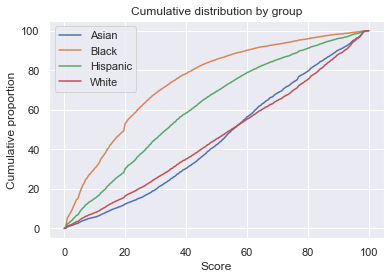

In [8]:
fig, ax = plt.subplots()

cdfs.plot(ax=ax)
ax.set_ylabel('Cumulative proportion')
ax.set_title('Cumulative distribution by group')

## ROC curves

See the discussion in the [Chapter 2 Case Study](https://fairmlbook.org/classification.html#case-study-credit-scoring) for details on the data.
The performance variable used in the fraction of people within that group and score that succeed; specifically, the fraction of people with that group and credit score who do not default. 

We can define the true positive rate as the rate of predicted positive performance given positive performance. 

In [16]:
# pdfs: Fraction of people in a group at each score level 
# (note: pdfs add to 100 in this data)
pdfs
# pdfs.sum(axis=0)
# performance: fraction of people in a group who succeed at each score
# note that fraction is out of 100
performance
# Approx. people in a group and at score who succeed
(pdfs * performance)
# People in a group and at score or below who succeed
(pdfs * (performance)).cumsum()
# Approx people in a group
(pdfs * (performance)).sum(axis=0)

# Easier to construct if we reverse the index
pdfs_rev = pdfs.sort_index(axis=0, ascending=False)
# performance_rev = performance.sort_index(axis=0, ascending=False)

# Approx. people in a group and at score who succeed
(pdfs_rev * performance_rev)
# People in a group succeeding at each score and higher 
(pdfs_rev * (performance_rev)).cumsum()
# The total number of people in a group
(pdfs_rev * (performance_rev)).sum(axis=0)

# True positive rate: fraction of people who received loan who
# don't default
tpr = (
    (pdfs_rev * (performance_rev)).cumsum()
    / (pdfs_rev * (performance_rev)).sum(axis=0)
)
# False positive rate: fraction of people who received loan who default
fpr = (
    (pdfs_rev * (100 - performance_rev)).cumsum()
    / (pdfs_rev * (100 - performance_rev)).sum(axis=0)
)
roc_df = pd.concat(
    [
        fpr, tpr
    ],
    axis=1, keys=['fpr', 'tpr'], names=['metric']
).swaplevel(axis=1).sort_index(axis=1, level=0)

# # Alternative:
# tpr = 1 - (
#     (pdfs * (performance)).cumsum()
#     / (pdfs * (performance)).sum(axis=0)
# )

# fpr = 1 - (
#     (pdfs * (100 - performance)).cumsum()
#     / (pdfs * (100 - performance)).sum(axis=0)
# )

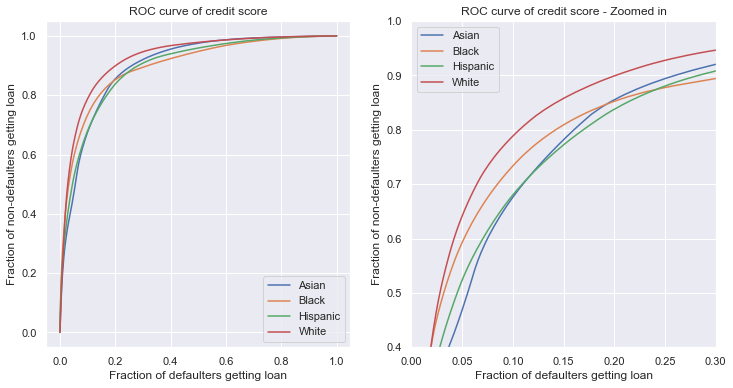

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for group in cdfs.columns:
    roc_df[group].plot(ax=ax[0], x='fpr', y='tpr', label=group)
    ax[0].set_title('ROC curve of credit score')
    ax[0].set_xlabel('Fraction of defaulters getting loan')
    ax[0].set_ylabel('Fraction of non-defaulters getting loan')
    
    roc_df[group].plot(ax=ax[1], x='fpr', y='tpr', label=group)
    ax[1].set_title('ROC curve of credit score - Zoomed in')
    ax[1].set_xlim(0, 0.3)
    ax[1].set_ylim(0.4, 1)
    ax[1].set_xlabel('Fraction of defaulters getting loan')
    ax[1].set_ylabel('Fraction of non-defaulters getting loan')

Takeaways:
* White group has a larger area under the curve than the black group
* ROCs with the same shape can correspond to different score functions
* Trade-off between TPR and FPR achieved at $t$ in one group could require a different threshold $t$ in another group